In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
import albumentations as A
import random
import urllib
from sklearn.model_selection import train_test_split
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Необходимо получить модель для нахождения логотипов на ищображениях счетов. Перед тем как обучать модель необходимо разметить данные. Я воспользовался VGG Image Annotator, чтобы получить csv файл с координатами нужной области.

Загрузим полученный файл.

In [ ]:
data_df = pd.read_csv('logos.csv')
data_df.head()

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,1.jpg,74250,{},1,0,"{""name"":""rect"",""x"":61,""y"":55,""width"":298,""heig...","{""object_name"":""forcestore""}"
1,2.jpg,98835,{},1,0,"{""name"":""rect"",""x"":725,""y"":13,""width"":130,""hei...","{""object_name"":""acc""}"
2,3.jpg,50346,{},1,0,"{""name"":""rect"",""x"":63,""y"":81,""width"":279,""heig...","{""object_name"":""acme1""}"
3,4.jpg,61253,{},1,0,"{""name"":""rect"",""x"":71,""y"":78,""width"":323,""heig...","{""object_name"":""acme2""}"
4,5.jpg,123266,{},1,0,"{""name"":""rect"",""x"":98,""y"":76,""width"":175,""heig...","{""object_name"":""sendgrid""}"


Координаты в файле представлены в виде строк. Преобразуем данные в более подходящий формат.

In [ ]:
DATASET_PATH = 'source'

In [ ]:
data_df['region_shape_attributes'] = data_df['region_shape_attributes'].apply(eval)
data_df['region_attributes'] = data_df['region_attributes'].apply(eval)
data_df['x1'] = data_df['region_shape_attributes'].apply(lambda x: x['x'])
data_df['y1'] = data_df['region_shape_attributes'].apply(lambda x: x['y'])
data_df['x2'] = data_df['region_shape_attributes'].apply(lambda x: x['x'] + x['width'])
data_df['y2'] = data_df['region_shape_attributes'].apply(lambda x: x['y'] + x['height'])
data_df['label'] = data_df['region_attributes'].apply(lambda x: x['object_name'])
data_df['#filename'] = data_df['#filename'].apply(lambda x: os.path.join(DATASET_PATH, x))
data_df.head()

,#filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,x1,y1,x2,y2,label
0,source/1.jpg,74250,{},1,0,"{'name': 'rect', 'x': 61, 'y': 55, 'width': 29...",{'object_name': 'forcestore'},61,55,359,133,forcestore
1,source/2.jpg,98835,{},1,0,"{'name': 'rect', 'x': 725, 'y': 13, 'width': 1...",{'object_name': 'acc'},725,13,855,124,acc
2,source/3.jpg,50346,{},1,0,"{'name': 'rect', 'x': 63, 'y': 81, 'width': 27...",{'object_name': 'acme1'},63,81,342,184,acme1
3,source/4.jpg,61253,{},1,0,"{'name': 'rect', 'x': 71, 'y': 78, 'width': 32...",{'object_name': 'acme2'},71,78,394,219,acme2
4,source/5.jpg,123266,{},1,0,"{'name': 'rect', 'x': 98, 'y': 76, 'width': 17...",{'object_name': 'sendgrid'},98,76,273,125,sendgrid


Теперь посмотрим на изображения.

In [ ]:
def visualize_bbox(img, bbox, thickness=2):
    '''
    Рисует ограничительную рамку на изображении img по координатам bbox.

    image - ndarray, матрица с изображением;
    bbox - ораничительная рамка изображения вида [x1, y1, x2, y2];
    thickness - int, толщина линий рамки.
    -----------------
    return - ndarray матрицы изображения с нарисованной рамкой.
    '''
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=thickness)
    return img

In [ ]:
def show_image(image, bbox):
    '''
    Выводит изображение с ограничительной рамкой.

    image - ndarray, матрица с изображением;
    bbox - ораничительная рамка изображения вида [x1, y1, x2, y2].
    '''
    image = visualize_bbox(image.copy(), bbox)
    f = plt.figure(figsize=(18, 12))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()

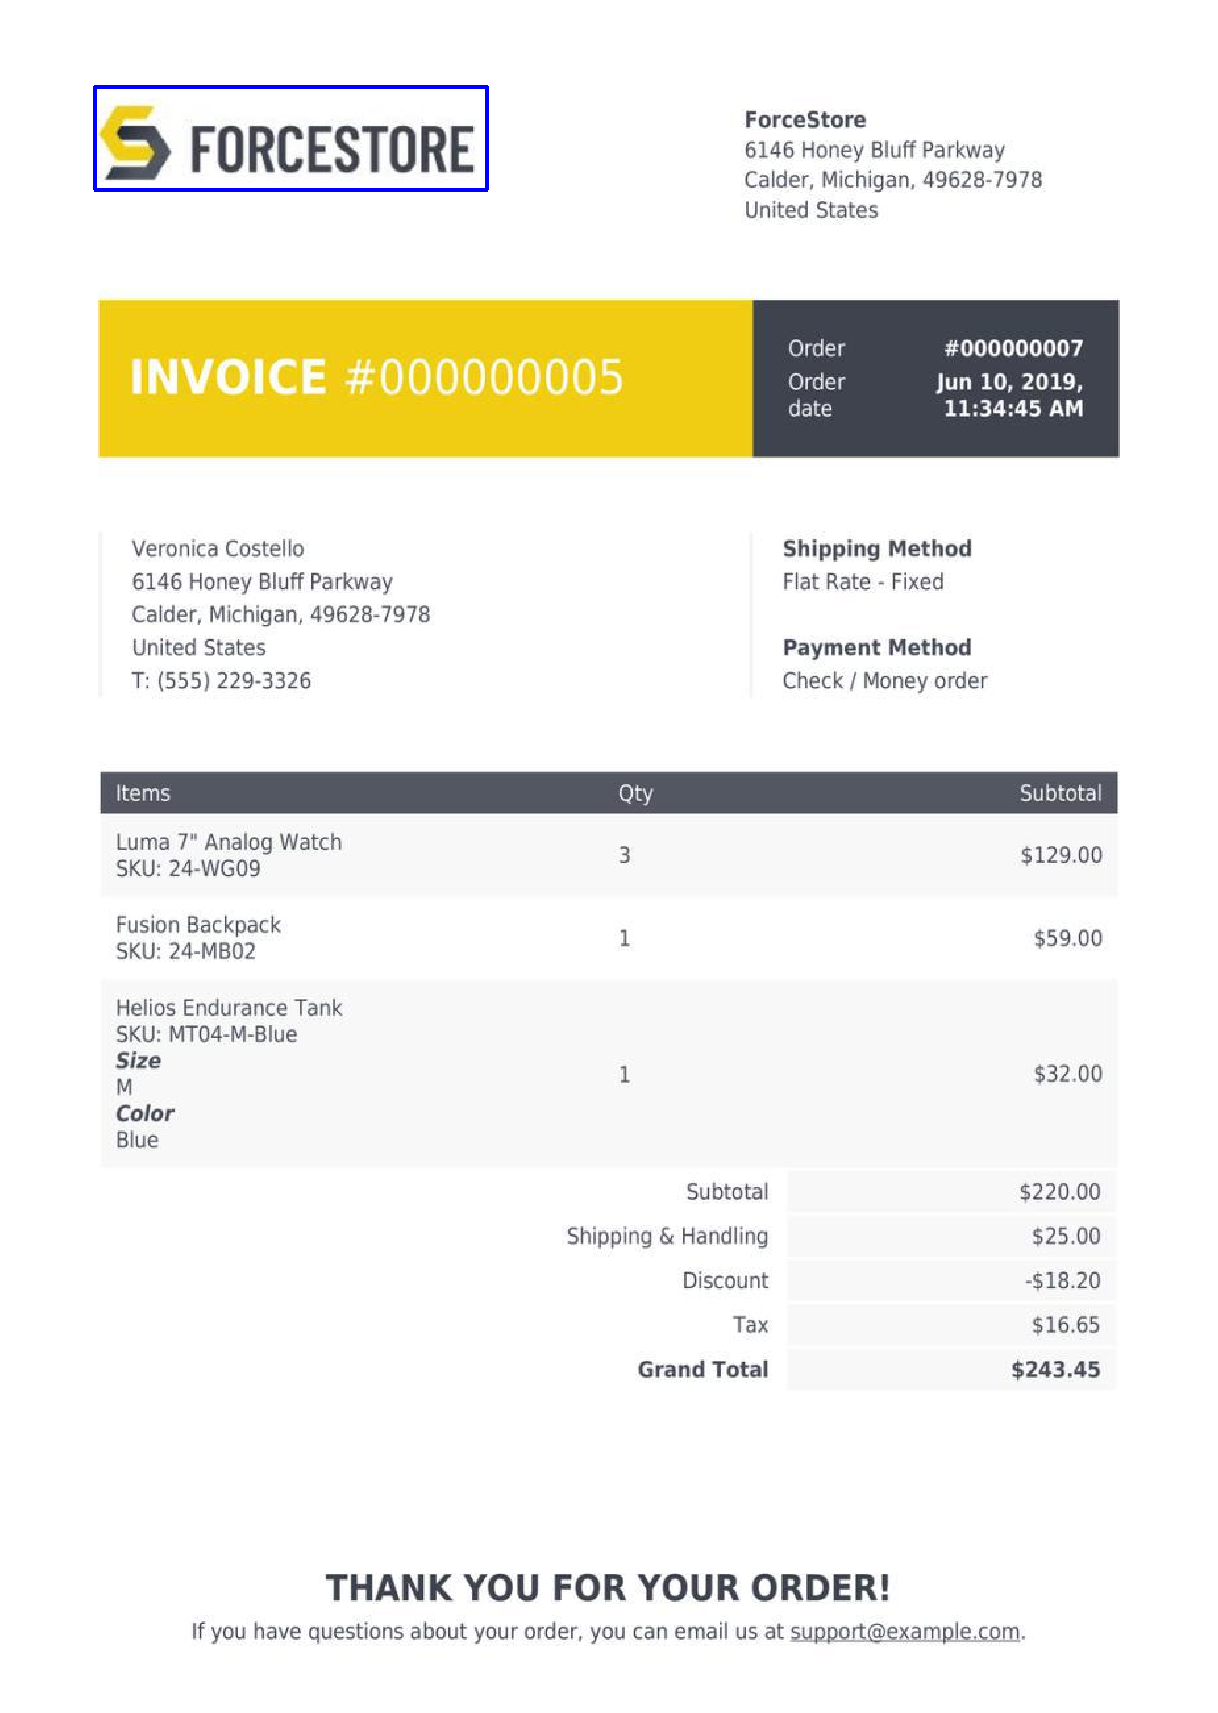

In [ ]:
img = cv2.imread(data_df.iloc[0]['#filename'])
show_image(img, data_df.iloc[0].loc['x1':'y2'].to_list())

Нам дано только по одному примеру для каждого логотипа. Этого мало чтобы обучить модель. Поэтому можно использовать обученную заранее модель на большом количестве данных и потом ее дообучить на наших данных. 

Чтобы увелиить количество обучаюющих примеров можно прибегнуть к аугментации изображений. Мы будем добавлять случайные искажения на исходные изображения. Также это сделает модель устойчивой к искажениям данных.

Аугментация изображений:
- Flip - переворот;
- RandomGamma - изменение гаммы;
- RandomBrightnessContrast - изменение яркости;
- Rotate - поворот на случайный угол;
- RandomRotate90 - поворот на 90;
- ToGray - в задании сказано, что изображения могут быть ч/б, поэтому добавим соответствующее преобразование;
- GaussNoise - случайный шум.

Также установим праметры изменеия bbox вместе с изображением.

In [ ]:
bbox_params = A.BboxParams(
  format='pascal_voc', 
  min_area=1, 
  min_visibility=0.5, 
  label_fields=['field_id']
)

In [ ]:
aug_compose = A.Compose([
    A.Flip(p=0.25),
    A.RandomGamma(gamma_limit=(20, 300), p=0.5),
    A.RandomBrightnessContrast(p=0.85),
    A.Rotate(limit=35, p=0.9),
    A.RandomRotate90(p=0.25),
    A.ToGray(p=0.5),
    A.GaussNoise(p=0.25)
], bbox_params=bbox_params)

Посмотрим на возможное преобразование изображения.

In [ ]:
def show_augmented(augmentation, image, bbox):
    '''
    Выводит изображение с применными преобразованиями.

    augmentation - преобразования изображения;
    image - cv2.imread изображение
    '''
    augmented = augmentation(image=image, bboxes=[bbox], field_id=['1'])
    show_image(augmented['image'], augmented['bboxes'][0])

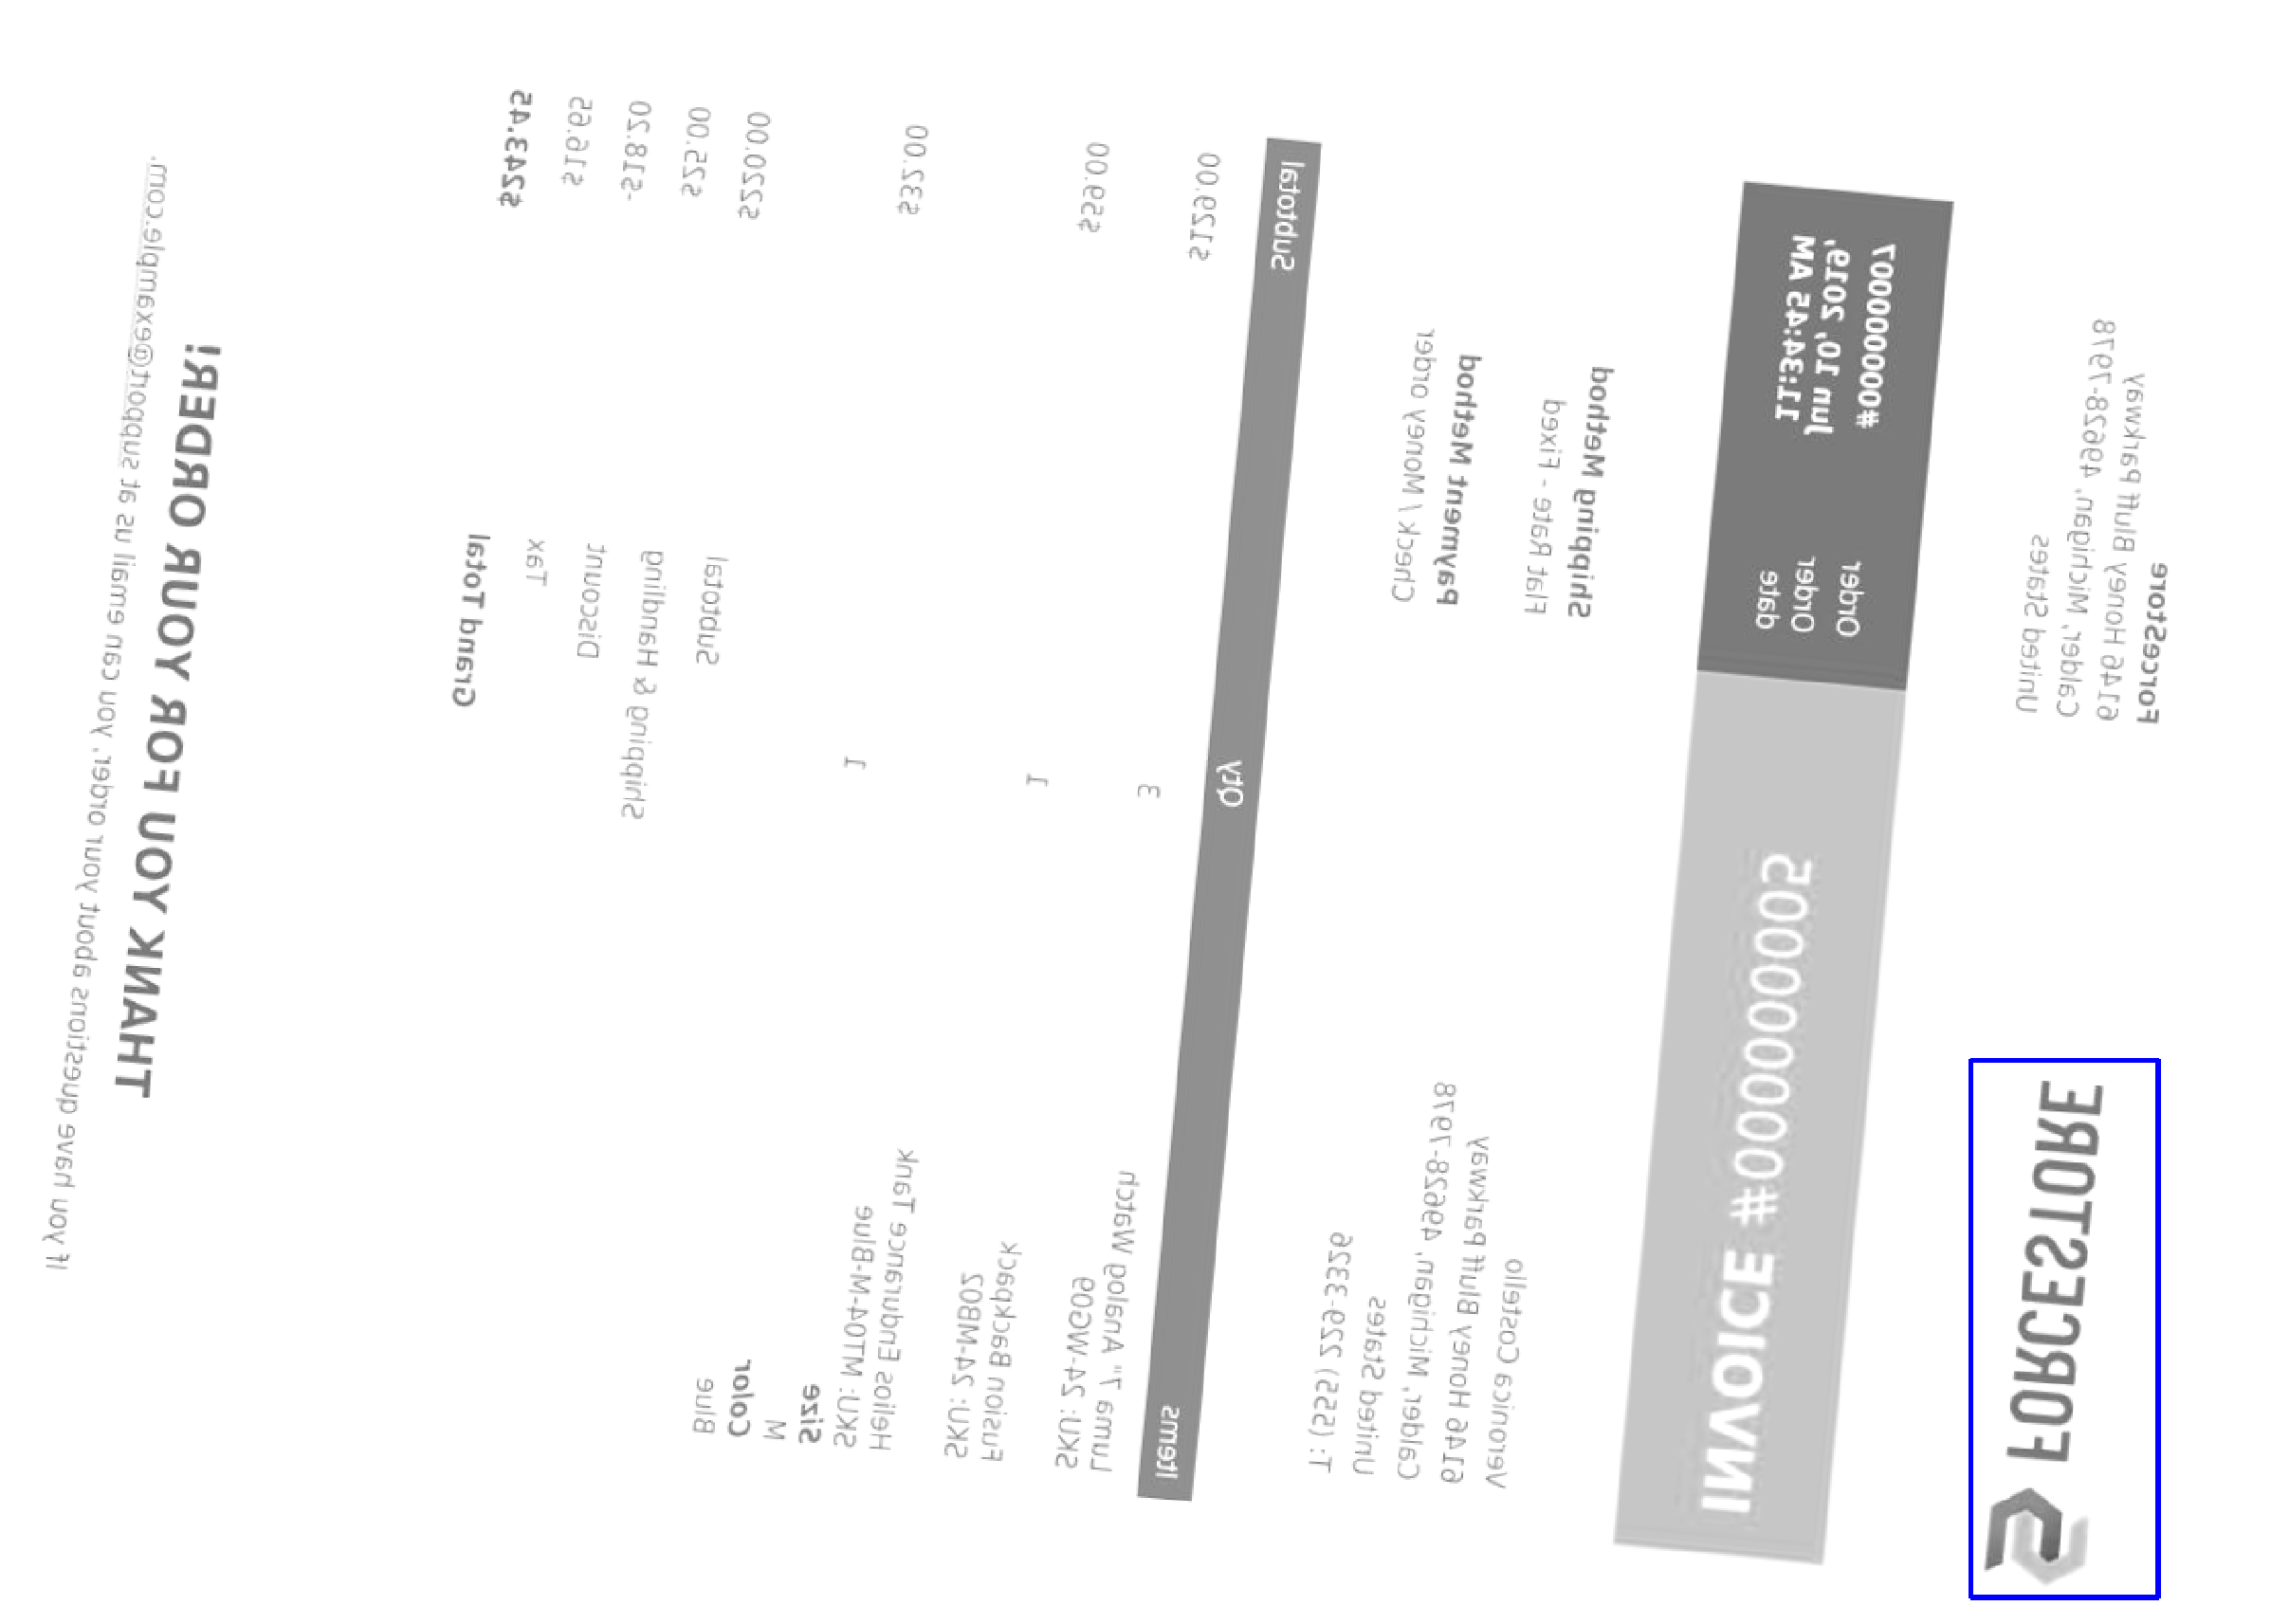

In [ ]:
show_augmented(aug_compose, img, data_df[['x1', 'y1', 'x2', 'y2']].iloc[0].to_list())

Теперь создадим новые изображения с примененными преобразованиями.

In [ ]:
def images_aug(aug, num, img_path, labels, bboxes, save_path):
    '''
    Создает новые аугментированные изображения. Изображения сохраняются в
    save_path. DataFrame с информацией о изображениях 
    сохраняется текущую директорию.

    aug - преобразования изображений;
    num - int, количество новых изображений на каждое исходное;
    img_path - iterable, пути к изображениям;
    labels - iterable, классы изображений;
    bboxes - iterable, ограничивающие рамки изображений;
    save_path - str, путь сохранения новых изображений.
    
    return:
    ---------------
    rows - DataFrame с колонками [file_name, x_min, y_min, x_max, y_max, class].
    '''
    # создаем директорию для данных
    os.makedirs(save_path, exist_ok=True)

    rows = []
    for path, label, bbox in tqdm(zip(img_path, labels, bboxes), desc='Augmenteting images'):
        image = cv2.imread(path)
        for i in range(num):
            #применяем преобразованя
            augmented = aug(image=image, bboxes=[bbox], field_id=['1'])
            file_name = os.path.basename(path)
            file_name = file_name.split('.')[0]
            file_name = f'{file_name}_{i}.jpg'
            #получаем новые значения координат для каждой рамки
            for aug_bbox in augmented['bboxes']:
                x_min, y_min, x_max, y_max = map(lambda v: int(v), aug_bbox)
                rows.append({
                  'file_name': os.path.join(save_path, file_name),
                  'x_min': x_min,
                  'y_min': y_min,
                  'x_max': x_max,
                  'y_max': y_max,
                  'class': label
                })
            #созраняем новое изображение
            cv2.imwrite(os.path.join(save_path, file_name), augmented['image'])
    
    rows = pd.DataFrame(rows)
    
    return rows

In [ ]:
SAVE_PATH = 'augmented/images'

In [ ]:
aug_df = images_aug(aug_compose, 30, data_df['#filename'], data_df['label'], data_df[['x1', 'y1', 'x2', 'y2']].values, SAVE_PATH)

Augmenteting images: 7it [00:21,  3.02s/it]


In [ ]:
aug_df.to_csv('images.csv', index=None)

In [ ]:
aug_df.head()

,file_name,x_min,y_min,x_max,y_max,class
0,augmented/images/1_0.jpg,1000,0,1167,205,forcestore
1,augmented/images/1_1.jpg,60,1147,359,1225,forcestore
2,augmented/images/1_2.jpg,360,0,658,152,forcestore
3,augmented/images/1_3.jpg,39,82,129,383,forcestore
4,augmented/images/1_4.jpg,184,0,492,125,forcestore


Мы получили DataFrame с путем к файлу, координатами и классом изобрражения. Разделим данные изображения на тестовую и обучающию подвыборки.

In [ ]:
train_df, test_df = train_test_split(
  aug_df,
  test_size=0.2,
  random_state=RANDOM_SEED
)

Для нахождения логотипов будет использоваться модель RetinaNet обученная предварительно на датасете Coco. Данная модель обучалась на большом количеств данных с объектами из повседневной жизни. Это не является непосредственно нашим случаем, но основные закономерности в изображениях данная модель должна хорошо улавливать. RetinaNet для обучения требует два файла:
- ANNOTATIONS_FILE - файл с данными для обучения (train_df);
- CLASSES_FILE - файл со словарем, сопостовляющим имя класса с его номером.

Создадим данные файлы.

In [ ]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [ ]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [ ]:
test_df.to_csv('test.csv', index=False, header=None)

In [ ]:
classes = enumerate(sorted(set(data_df['label'])))

with open(CLASSES_FILE, 'w') as f:
    for i, line in classes:
        f.write('{},{}\n'.format(line,i))

Загрузим с github предобученну модель.

In [ ]:
os.makedirs("snapshots", exist_ok=True)

In [ ]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

In [60]:
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


Запустим модель для дообучения на наших данных, указав стартовые веса.

In [10]:
!retinanet-train \
 --freeze-backbone \
 --weights {PRETRAINED_MODEL} \
 --batch-size 8 \
 --steps 500 \
 --epochs 10 \
 csv annotations.csv classes.csv

Using TensorFlow backend.
2020-04-02 16:00:40.452300: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-02 16:00:40.452403: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-02 16:00:40.452419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Creating model, this may take a second...
2020-04-02 16:00:41.505308: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORC

Я остановил модель на 7 эпохе, так как дальше ошибка падала не сильно, а модель обучается долго. Так же данных у нас не много и я не хотел допукать переобуения.

In [2]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

snapshots/resnet50_csv_07.h5


Проверим модель на тестовом наборе. Для этого преобразуем модель.

In [5]:
!retinanet-convert-model {model_path} weights/resnet50_csv_07.h5

Using TensorFlow backend.
2020-04-02 19:15:27.699625: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-02 19:15:27.699729: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-02 19:15:27.699749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],

Для оценки модель также требует два файла: с описнием файлов test.csv и с описанием классов classes.csv.

In [6]:
!retinanet-evaluate csv test.csv classes.csv weights/resnet50_csv_07.h5

Using TensorFlow backend.
2020-04-02 19:16:06.633215: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-02 19:16:06.633328: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-02 19:16:06.633359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Loading model, this may take a second...
2020-04-02 19:16:07.639260: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE

Молель обладает большой точностью (хотя примеров у нас немного).

Загрузим последнюю версию модели и преобразуем ее в формат Keras RetinaNet, чтобы посмотреть на предсказания более подробно.

In [3]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

In [13]:
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [ ]:
# словарь для обратного преобразования классов
labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

Добавим функции для получения предсказаний от модели и отрисовки их на изображениях.

In [ ]:
def predict(image):
    '''
    Предсказывает наличие объекта на изображении.

    image - ndarray, матрица с изображением.
    
    return:
    ---------
    boxes - ограничительные рамки, найденных объектов,
    scores - уверенности модели,
    labels - классы, найденных объектов.
    '''
    #преобразуем изображение перед подачей в модель
    image = preprocess_image(image.copy())
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(
        np.expand_dims(image, axis=0)
    )

    boxes /= scale

    return boxes, scores, labels

In [ ]:
def draw_detections(image, boxes, scores, labels, thres_score=.5):
    '''
    Рисует рамки вокруг найденных объектов.

    image - ndarray, матрица с изображением;
    boxes - ограничительные рамки, найденных объектов;
    scores - уверенности модели;
    labels - классы, найденных объектов.
    '''
    #найдем самый вероятный объект и обведем его, 
    #если он превышает thres_score
    max_index = scores[0].argmax()
    score = scores[0][max_index]
    box = boxes[0][max_index]
    label = labels[0][max_index]
    if score > thres_score:
        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

In [ ]:
def show_detected_objects(image_row, thres_score=.6):
    '''
    Выволит изобраение с найденным объектом.

    image_row - pd.Series вида [file_name, x_min, y_min, x_max, y_max].
    '''
    img_path = image_row.file_name

    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [
        image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
    ]
    draw_box(draw, true_box, color=(255, 255, 0))

    draw_detections(draw, boxes, scores, labels)

    plt.axis('off')
    plt.imshow(draw)
    plt.show()

Помотрим на работу модели на тестовых данных.

In [ ]:
#граница уверенности модели
THRES_SCORE = 0.5

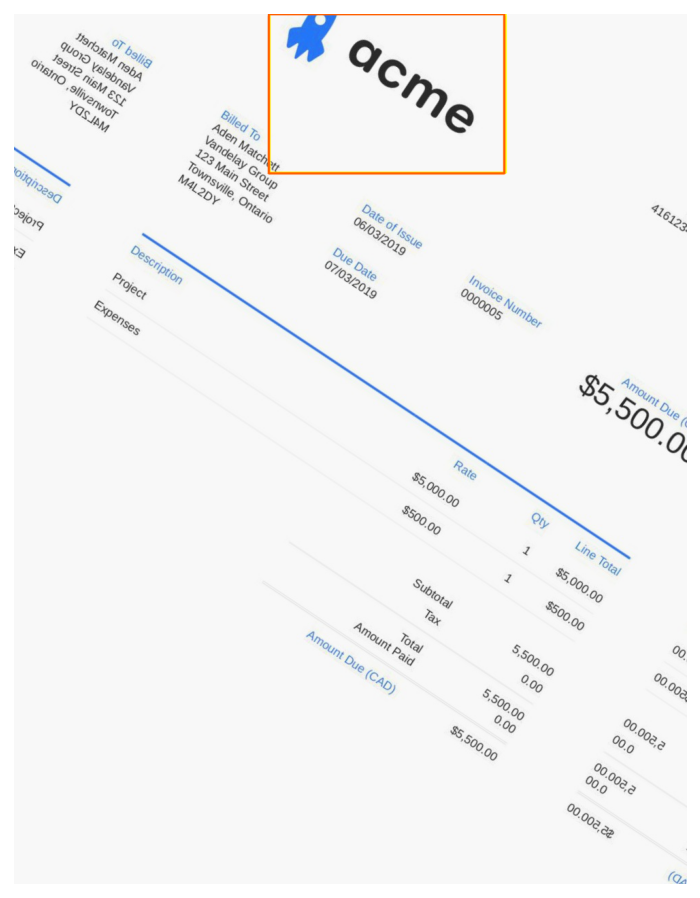

In [19]:
show_detected_objects(test_df.iloc[0], THRES_SCORE)

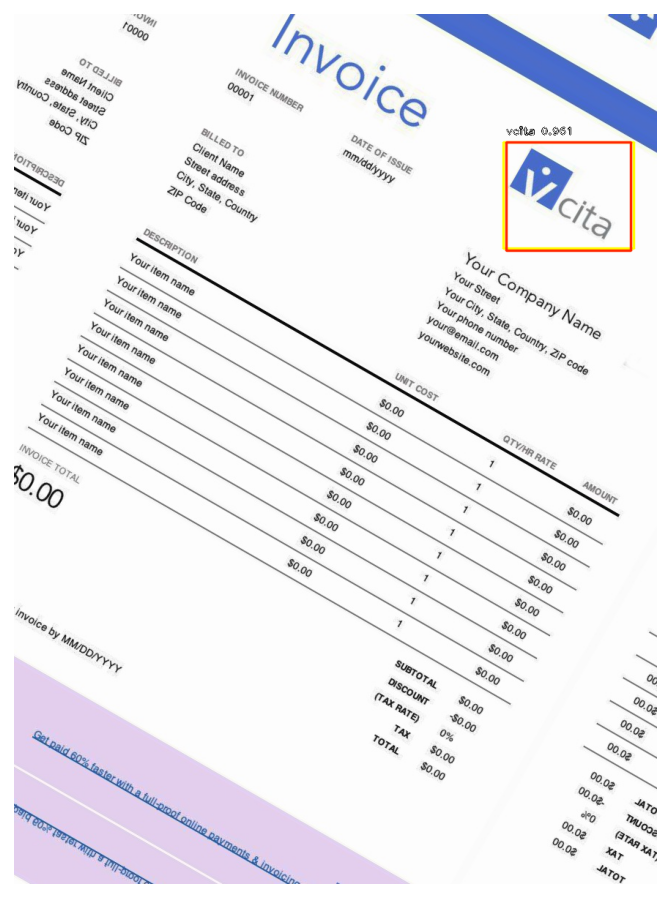

In [20]:
show_detected_objects(test_df.iloc[1])

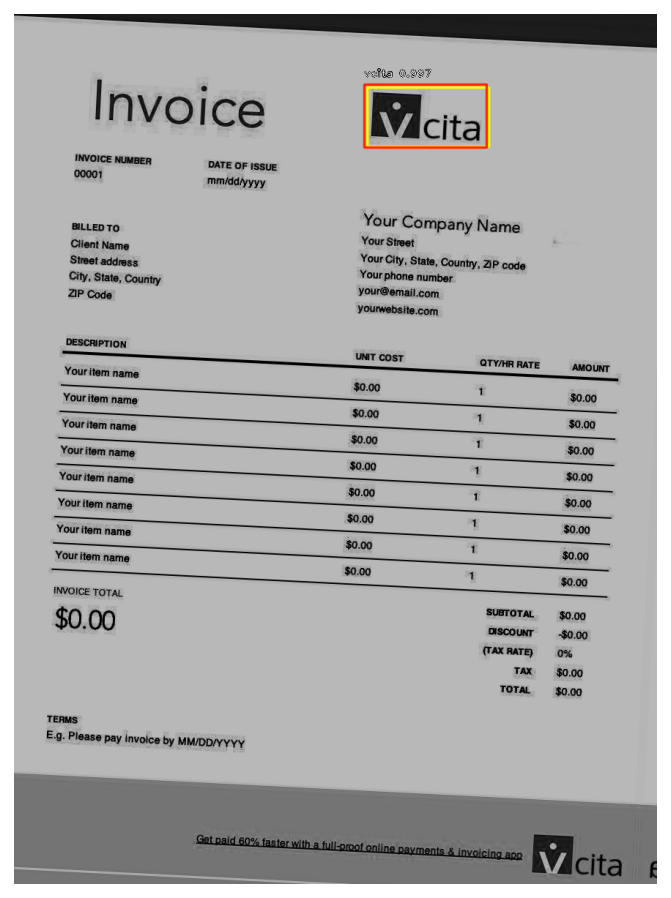

In [21]:
show_detected_objects(test_df.iloc[10])

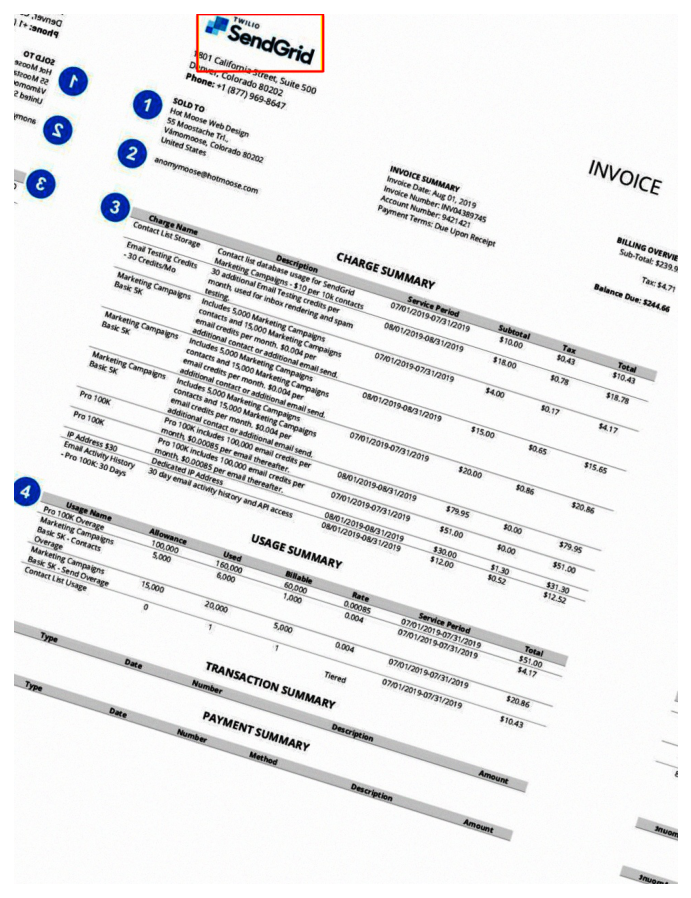

In [22]:
show_detected_objects(test_df.iloc[11])

Модель достаточно точно определяет положение логотипа. Теперь получим сам логотип из изображения.

In [8]:
def get_logotype(path, show=True, with_score_on=True):
    '''
    Отрисовывает логотип с его классом и уверенностью модели.

    path:          str путь к файлу
    show:          bool, если True, то изображение также выволится в ноутбук
    with_score_on: писать ли значение уверенности на логотипе
    
    return:
    ------------------
    logotype:   ndarray вырезанный логотип
    score:      float уверенность модели 
    '''
    image = read_image_bgr(path)
    # получаем предсказания с модели
    boxes, scores, labels = predict(image)
    # находим наиболее вероятный класс
    max_index = scores[0].argmax()
    score = scores[0][max_index]
    box = boxes[0][max_index]
    label = labels[0][max_index]

    box = box.astype(int)
    # вырезаем логотип
    logotype = image[box[1]:box[3], box[0]:box[2], :]

    if with_score_on:
        logo_with_score = logotype.copy()
        cv2.putText(logo_with_score, 
                "{} {:.3f}".format(labels_to_names[label], score),
                (0, logotype.shape[0]-5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 255)
                )
        cv2.imshow(
            '{} {:.3f}".format(labels_to_names[label], score)',
            logotype_with_score
        )
    else:
        cv2.imshow('{} {:.3f}".format(labels_to_names[label], score)', logotype)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # выводим в ноутбук, если надо
    if show:
        plt.axis('off')
        plt.imshow(logo_with_score)
        plt.show()

    return logotype, score

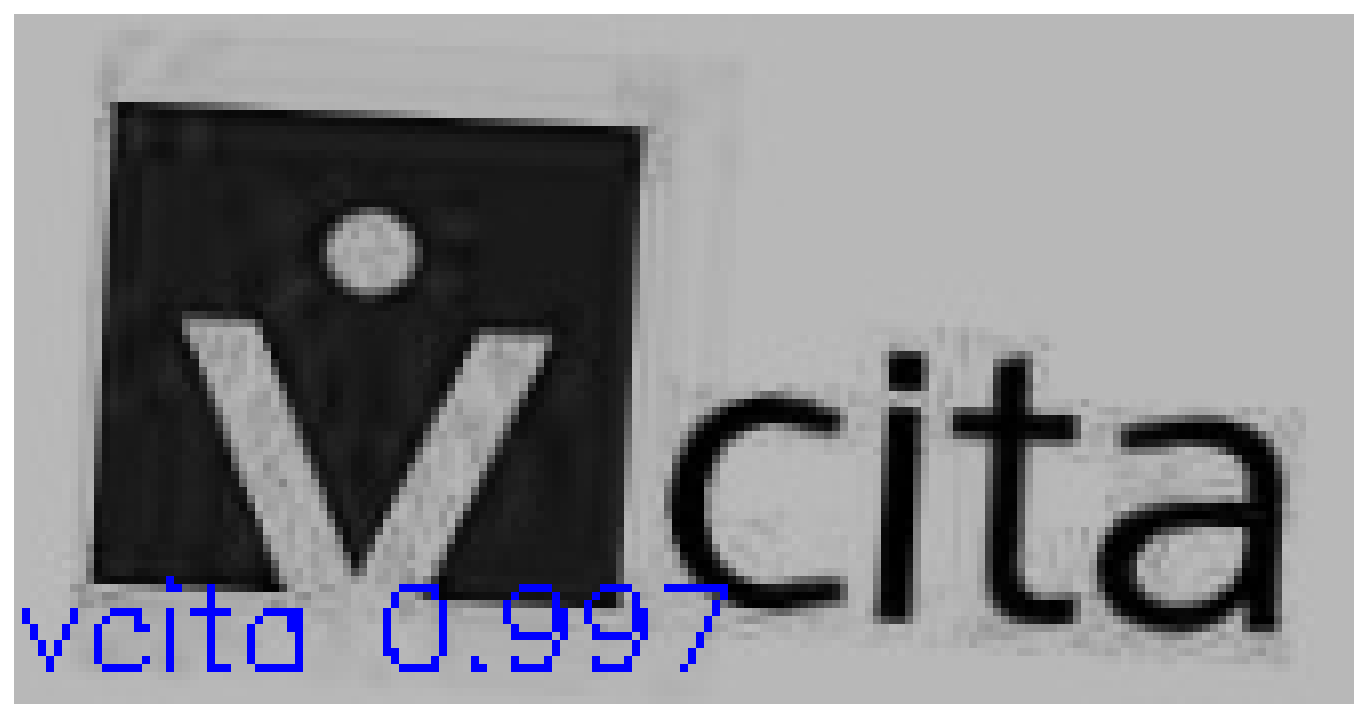

In [52]:
get_logotype(test_df.iloc[10]['file_name']);

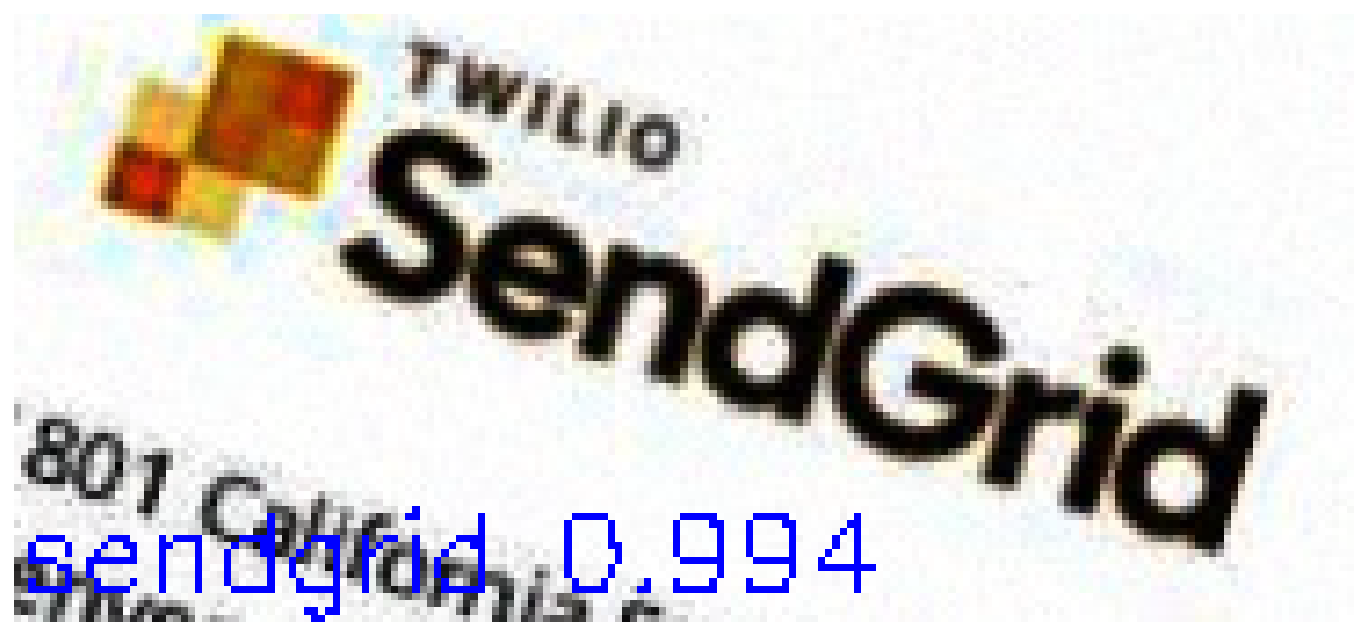

In [54]:
get_logotype(test_df.iloc[11]['file_name']);